# CFR

An Introduction to Counterfactual Regret Minimization

Papers: 

- http://modelai.gettysburg.edu/2013/cfr/cfr.pdf
- https://poker.cs.ualberta.ca/publications/NIPS07-cfr.pdf

In [49]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(suppress=True)

## Game of Rock, Paper, Scissors

In [79]:
N = 3


# Utility Matrix
# 0 - Rock, 1 - Paper, 2 - Scissors
def utility(p1, p2):
    if p1 == p2:
        return 0
    elif (p1 + 1) % N == p2:
        return -1
    else:
        return 1


def normalize(strategy):
    normSum = np.sum(strategy)
    return strategy / normSum if normSum > 0 else np.array(N * [1 / N], dtype=np.float64)


# get current strategy through regret-matching
def getStrategy(regretSum):
    strategy = np.maximum(regretSum, 0)
    return normalize(strategy)


# get random action based on mixed strategy
def getAction(strategy):
    return np.random.choice(N, p=strategy)


def getActionUtility(otherAction):
    actionUtility = np.zeros(N, dtype=np.float64)
    actionUtility[otherAction] = 0
    actionUtility[(otherAction + 1) % N] = 1
    actionUtility[(otherAction - 1) % N] = -1
    return actionUtility

## RPS: CFR vs. Fixed Strategy

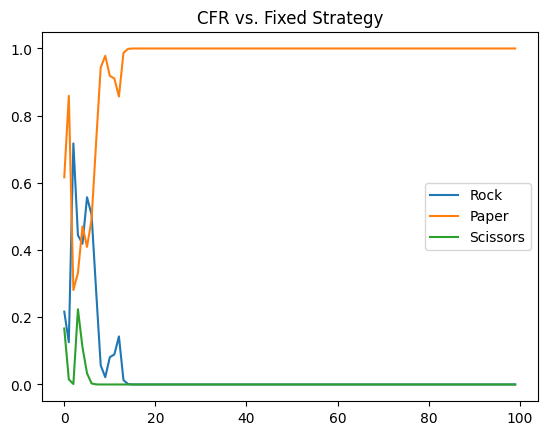

In [77]:
class RPSTrainer:
    def __init__(self):
        self.regretSum = np.zeros(N, dtype=np.float64)
        self.strategy = np.zeros(N, dtype=np.float64)
        self.strategySum = np.zeros(N, dtype=np.float64)
        self.oppStrategy = np.array([0.4, 0.3, 0.3], dtype=np.float64)

    def train(self, iterations):
        actionUtility = np.zeros(N, dtype=np.float64)
        for _ in range(iterations):
            # get regret-matched mixed-strategy actions
            self.strategy = getStrategy(self.regretSum)
            myAction = getAction(self.strategy)
            otherAction = getAction(self.oppStrategy)

            # compute action utilities
            actionUtility[otherAction] = 0
            actionUtility[(otherAction + 1) % N] = 1
            actionUtility[(otherAction - 1) % N] = -1

            # accumulate regrets and strategy
            self.regretSum += actionUtility - actionUtility[myAction]
            self.strategySum += self.strategy

    def getAverageStrategy(self):
        return normalize(self.strategySum).copy()


trainer = RPSTrainer()
res = []
for i in range(100):
    trainer.train(10)
    res.append(trainer.getAverageStrategy())
res = np.array(res)

plt.plot(res[:, 0], label='Rock')
plt.plot(res[:, 1], label='Paper')
plt.plot(res[:, 2], label='Scissors')
plt.title('CFR vs. Fixed Strategy')
plt.legend()
plt.show()


## RPS: CFR vs. CFR

In [103]:
class RPSTrainer2:
    def __init__(self):
        # Player 1
        self.regretSum1 = np.zeros(N, dtype=np.float64)
        self.strategy1 = np.zeros(N, dtype=np.float64)
        self.strategySum1 = np.zeros(N, dtype=np.float64)

        # Player 2
        self.regretSum2 = np.zeros(N, dtype=np.float64)
        self.strategy2 = np.zeros(N, dtype=np.float64)
        self.strategySum2 = np.zeros(N, dtype=np.float64)

    def train(self, iterations):
        for i in range(iterations):
            self.strategy1 = getStrategy(self.regretSum1)
            self.strategy2 = getStrategy(self.regretSum2)

            action1 = getAction(self.strategy1)
            action2 = getAction(self.strategy2)

            actionUtility1 = getActionUtility(action2)
            actionUtility2 = getActionUtility(action1)

            self.regretSum1 += actionUtility1 - actionUtility1[action1]
            self.regretSum2 += actionUtility2 - actionUtility2[action2]

            self.strategySum1 += self.strategy1
            self.strategySum2 += self.strategy2

    def getAverageStrategy1(self):
        return normalize(self.strategySum1).copy()

    def getAverageStrategy2(self):
        return normalize(self.strategySum2).copy()


trainer = RPSTrainer2()
res = []
for i in range(10):
    trainer.train(1)
    res.append(trainer.getAverageStrategy1())
res = np.array(res)